**Objective**: Train multiple deep survival models.

**Table of content:**
1. Train / val split
2. ML models 
3. DeepSurv 
4. DeepHit

In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import pickle
import warnings
warnings.filterwarnings("ignore")

import os
path_dir = os.path.dirname(os.getcwd())

import plotly
plotly.offline.init_notebook_mode()
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
pio.renderers.default='svg'

%load_ext autoreload
%autoreload 2

In [ ]:
cd ../src/

In [53]:
from train import *
from train_survival_ml import *
from train_survival_deep import *

In [54]:
df = pd.read_csv(os.path.join(path_dir, "outputs", "data", "hdhi_clean.csv"))

In [55]:
# Parameters

scaler_name = "StandardScaler" #MinMaxScaler
random_state = 123

# 1. Train / val split

In [56]:
# covariate columns

cols_x = [
    'age', 
    'duration_of_stay', 'duration_of_intensive_unit_stay', 'smoking',
    'alcohol', 'dm', 'htn', 'cad', 'prior_cmp', 'ckd', 'hb', 'tlc',
    'platelets', 'glucose', 'urea', 'creatinine', 'bnp',
    'raised_cardiac_enzymes', 'ef', 'severe_anaemia', 'anaemia',
    'stable_angina', 'acs', 'stemi', 'atypical_chest_pain', 'heart_failure',
    'hfref', 'hfnef', 'valvular', 'chb', 'sss', 'aki', 'cva_infract',
    'cva_bleed', 'af', 'vt', 'psvt', 'congenital', 'uti',
    'neuro_cardiogenic_syncope', 'orthostatic', 'infective_endocarditis',
    'dvt', 'cardiogenic_shock', 'shock', 'pulmonary_embolism',
    'chest_infection', 'gender=F',
    'type_adm=E', 'first_visit',
    'nb_visits', 'duration_of_stay_lag1',
    'duration_of_intensive_unit_stay_lag1', 'cardiogenic_shock_lag1',
    'cad_lag1', 'time_before_readm_lag1'
]

col_target = "time_before_readm"

In [57]:
Xy_train_val, Xy_test, y_train_val, y_test = split_train_test(
    df, cols_x, col_target, test_size=0.2, col_stratify= "censored", 
    dropna=False,
    random_state=random_state)

Xy_train, Xy_val, y_train, y_val = split_train_test(
    Xy_train_val, cols_x, col_target, test_size=0.25, col_stratify= "censored", 
    dropna=False,
    random_state=random_state)

n_train, n_val, n_test = Xy_train.shape[0], Xy_val.shape[0], Xy_test.shape[0]
n_tot =  n_train + n_val + n_test

print("Train: {}%, Val: {}%, Test: {}%".format(
    round(n_train/n_tot *100),
    round(n_val/n_tot *100),
    round(n_test/n_tot *100)
))

Train: 60%, Val: 20%, Test: 20%


In [58]:
tmp = df.isna().sum()

means = {}
for c in tmp[tmp>0].index:
    if c in cols_x:
        means[c] = Xy_train_val[c].mean()
        Xy_train_val[c].fillna(means[c], inplace=True)
        
        Xy_train[c].fillna(means[c], inplace=True)
        Xy_val[c].fillna(means[c], inplace=True)
        Xy_test[c].fillna(means[c], inplace=True)
        
with open(os.path.join(path_dir, 'outputs', 'data', 'imputation_values.pkl'), 'wb') as f:
    pickle.dump(means, f)  

In [59]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# rescale
scaler = eval(scaler_name)()

Xy_train_val[cols_x] = scaler.fit_transform(Xy_train_val[cols_x])
Xy_train[cols_x] = scaler.transform(Xy_train[cols_x])
Xy_val[cols_x] = scaler.transform(Xy_val[cols_x])
Xy_test[cols_x] = scaler.transform(Xy_test[cols_x])

In [60]:
with open(os.path.join(path_dir, 'outputs', 'data', 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)  
    
map_data = {
    'train_x': Xy_train[cols_x+[col_target, 'censored']], 
    'val_x': Xy_val[cols_x+[col_target, 'censored']],
    'test_x': Xy_test[cols_x+[col_target, 'censored']],
    'train_y': y_train, 
    'val_y': y_val,
    'test_y': y_test,
}

for k,v in map_data.items():
    with open(os.path.join(path_dir, 'outputs', 'data',f'{k}.pkl'), 'wb') as f:
        pickle.dump(v, f)

# 2. ML models

In [64]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.svm import FastSurvivalSVM 

estimators = {
    'cox_ph' : CoxPHSurvivalAnalysis(alpha=0.5),
    'gboost': GradientBoostingSurvivalAnalysis(
        n_estimators=20,
        max_depth=2, 
        learning_rate=0.01,
        random_state= random_state,
        loss="coxph",
        verbose=0
    ),
    "svm": FastSurvivalSVM(alpha = 0.5, random_state=random_state)   
}

In [67]:
scores = {}

for name, estimator in estimators.items():
    print(name)
    estimator.fit(Xy_train[cols_x], y_train)
    scores[name] = {
        'train' : estimator.score(Xy_train[cols_x], y_train),
        'test' : estimator.score(Xy_val[cols_x], y_val)
    }
    
    with open(os.path.join(path_dir, "outputs","models",name+"_hospitalisation.pkl"), "wb") as f:
        pickle.dump(estimator, f)
    
    if name == "cox_ph":
        feat_importance_cox, fig = plot_feat_imp(cols_x, estimator.coef_)
        
scores_ml_df = pd.DataFrame.from_dict(scores)
scores_ml_df

cox_ph
gboost
svm


,cox_ph,gboost,svm
train,0.636494,0.601354,0.641222
test,0.631646,0.600562,0.636686


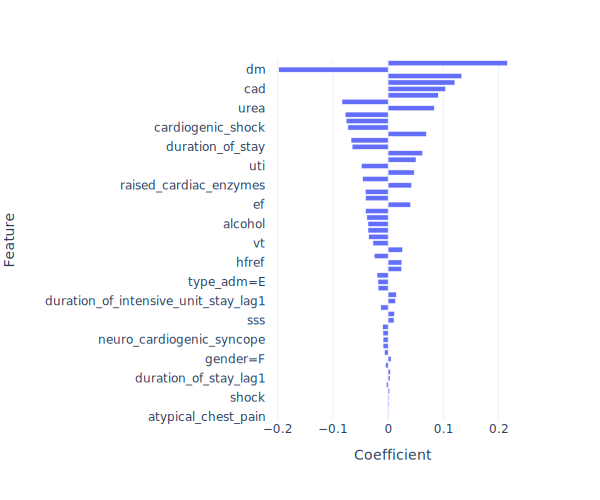

In [68]:
fig

# 3. DeepSurv

In [16]:
get_target = lambda df: (df[col_target].values, df['censored'].values)

y_train = get_target(Xy_train)
y_val = get_target(Xy_val)
y_test = get_target(Xy_test)

train = (np.array(Xy_train[cols_x]).astype(np.float32), y_train)
val = (np.array(Xy_val[cols_x]).astype(np.float32), y_val)
test = (np.array(Xy_test[cols_x]).astype(np.float32), y_test)

concordance: 0.64975
0:	[1s / 1s],		train_loss: 1.7820,	val_loss: 1.7240
1:	[0s / 1s],		train_loss: 1.7263,	val_loss: 1.7079
2:	[0s / 2s],		train_loss: 1.7170,	val_loss: 1.6947
3:	[0s / 3s],		train_loss: 1.7032,	val_loss: 1.6967
4:	[0s / 3s],		train_loss: 1.7025,	val_loss: 1.6966
concordance: 0.68097
5:	[0s / 4s],		train_loss: 1.6975,	val_loss: 1.6847
6:	[0s / 4s],		train_loss: 1.6848,	val_loss: 1.6849
7:	[0s / 5s],		train_loss: 1.6827,	val_loss: 1.6807
8:	[0s / 6s],		train_loss: 1.6824,	val_loss: 1.6878
9:	[0s / 6s],		train_loss: 1.6715,	val_loss: 1.6769
concordance: 0.68525
10:	[0s / 7s],		train_loss: 1.6747,	val_loss: 1.6912
11:	[0s / 8s],		train_loss: 1.6848,	val_loss: 1.6915
12:	[0s / 8s],		train_loss: 1.6821,	val_loss: 1.6913
13:	[0s / 9s],		train_loss: 1.6732,	val_loss: 1.6889
14:	[0s / 9s],		train_loss: 1.6695,	val_loss: 1.6736
concordance: 0.68793
15:	[0s / 10s],		train_loss: 1.6675,	val_loss: 1.6856
16:	[0s / 11s],		train_loss: 1.6680,	val_loss: 1.6893
17:	[0s / 11s],		train_

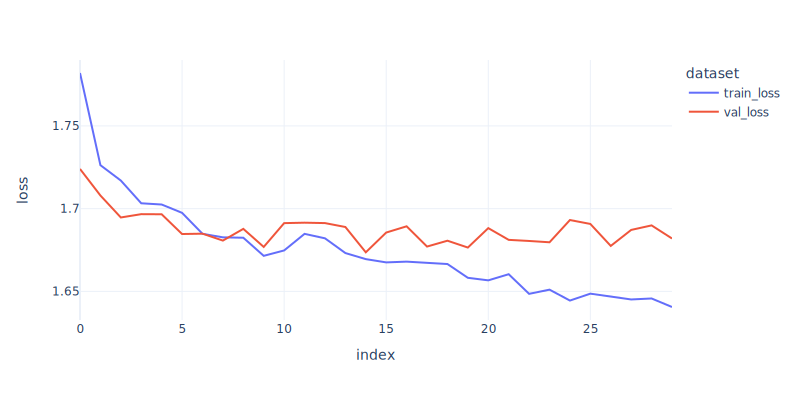

score {'train': 0.7157914024437165, 'val': 0.6932347887797408, 'test': 0.6851004525920107}


In [17]:
from pycox.models import LogisticHazard, PMF, DeepHitSingle, CoxPH

params = {
    'n_nodes': 34,
    'n_layers': 2,
    'dropout': 0.1,
    'lr':0.01, 
    'batch_size': 16,
}


logs_df, model, scores = train_deep_surv(
    train, val, test, CoxPH, out_features = 1, tolerance=10, 
    print_lr=True, print_logs=True, verbose = True,
    **params
)

print('score', scores)

In [18]:
scores

{'train': 0.7157914024437165,
 'val': 0.6932347887797408,
 'test': 0.6851004525920107}

In [19]:
grid_params = {
    "n_nodes" :[32, 64, 128],
    "n_layers" :[2, 3, 4],
    "dropout" :[0.1,0.3, 0.4],
    "lr" :[0.01]
}

best_model, table = grid_search_deep(train, val, test, 1, grid_params, CoxPH)

27 total scenario to run
1/27: params: {'n_nodes': 32, 'n_layers': 2, 'dropout': 0.1, 'lr': 0.01}
concordance: 0.66501
0:	[0s / 0s],		train_loss: 1.7758,	val_loss: 1.7152
1:	[0s / 1s],		train_loss: 1.7292,	val_loss: 1.7063
2:	[0s / 2s],		train_loss: 1.7149,	val_loss: 1.6959
3:	[0s / 2s],		train_loss: 1.7058,	val_loss: 1.6975
4:	[0s / 3s],		train_loss: 1.7016,	val_loss: 1.6964
concordance: 0.68202
5:	[0s / 3s],		train_loss: 1.6988,	val_loss: 1.6833
6:	[0s / 4s],		train_loss: 1.6933,	val_loss: 1.6802
7:	[0s / 5s],		train_loss: 1.6880,	val_loss: 1.6819
8:	[0s / 5s],		train_loss: 1.6904,	val_loss: 1.6811
9:	[0s / 6s],		train_loss: 1.6809,	val_loss: 1.6779
concordance: 0.67979
10:	[0s / 6s],		train_loss: 1.6717,	val_loss: 1.6823
11:	[0s / 7s],		train_loss: 1.6672,	val_loss: 1.6993
12:	[0s / 8s],		train_loss: 1.6671,	val_loss: 1.6821
13:	[0s / 8s],		train_loss: 1.6695,	val_loss: 1.6747
14:	[0s / 9s],		train_loss: 1.6711,	val_loss: 1.6826
concordance: 0.68706
15:	[0s / 10s],		train_loss: 1.66

2:	[0s / 2s],		train_loss: 1.7215,	val_loss: 1.7001
3:	[0s / 3s],		train_loss: 1.7078,	val_loss: 1.7070
4:	[0s / 4s],		train_loss: 1.7005,	val_loss: 1.6931
concordance: 0.682
5:	[0s / 5s],		train_loss: 1.7001,	val_loss: 1.6968
6:	[0s / 6s],		train_loss: 1.6917,	val_loss: 1.6959
7:	[0s / 7s],		train_loss: 1.6867,	val_loss: 1.6845
8:	[0s / 7s],		train_loss: 1.6803,	val_loss: 1.6840
9:	[0s / 8s],		train_loss: 1.6776,	val_loss: 1.6870
concordance: 0.69103
10:	[0s / 9s],		train_loss: 1.6809,	val_loss: 1.6741
11:	[0s / 10s],		train_loss: 1.6763,	val_loss: 1.6834
12:	[0s / 11s],		train_loss: 1.6674,	val_loss: 1.6852
13:	[0s / 12s],		train_loss: 1.6676,	val_loss: 1.6801
14:	[0s / 12s],		train_loss: 1.6739,	val_loss: 1.6782
concordance: 0.68575
15:	[0s / 13s],		train_loss: 1.6658,	val_loss: 1.6776
16:	[0s / 14s],		train_loss: 1.6633,	val_loss: 1.6759
17:	[0s / 15s],		train_loss: 1.6562,	val_loss: 1.6862
18:	[0s / 16s],		train_loss: 1.6616,	val_loss: 1.6782
19:	[0s / 17s],		train_loss: 1.6547,	v

66:	[0s / 56s],		train_loss: 1.6794,	val_loss: 1.6790
67:	[0s / 57s],		train_loss: 1.6846,	val_loss: 1.6726
68:	[0s / 58s],		train_loss: 1.6777,	val_loss: 1.6742
69:	[0s / 59s],		train_loss: 1.6792,	val_loss: 1.6914
concordance: 0.69186
70:	[0s / 1m:0s],		train_loss: 1.6893,	val_loss: 1.6929
71:	[0s / 1m:1s],		train_loss: 1.6741,	val_loss: 1.6704
Current score: 0.6842944243195918 vs. best score: 0.6881716126646339
7/27: params: {'n_nodes': 32, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.01}
concordance: 0.62095
0:	[1s / 1s],		train_loss: 1.8048,	val_loss: 1.7568
1:	[1s / 2s],		train_loss: 1.7524,	val_loss: 1.7246
2:	[1s / 3s],		train_loss: 1.7313,	val_loss: 1.7122
3:	[1s / 4s],		train_loss: 1.7236,	val_loss: 1.6995
4:	[1s / 5s],		train_loss: 1.7073,	val_loss: 1.6930
concordance: 0.67935
5:	[1s / 6s],		train_loss: 1.7078,	val_loss: 1.6997
6:	[1s / 7s],		train_loss: 1.6985,	val_loss: 1.6890
7:	[1s / 8s],		train_loss: 1.6958,	val_loss: 1.6882
8:	[1s / 9s],		train_loss: 1.6913,	val_loss: 1.7080

2:	[0s / 2s],		train_loss: 1.7164,	val_loss: 1.7011
3:	[0s / 2s],		train_loss: 1.6999,	val_loss: 1.7001
4:	[0s / 3s],		train_loss: 1.6865,	val_loss: 1.6901
concordance: 0.68388
5:	[0s / 4s],		train_loss: 1.6871,	val_loss: 1.6914
6:	[0s / 4s],		train_loss: 1.6825,	val_loss: 1.6818
7:	[0s / 5s],		train_loss: 1.6802,	val_loss: 1.6828
8:	[0s / 5s],		train_loss: 1.6775,	val_loss: 1.6831
9:	[0s / 6s],		train_loss: 1.6752,	val_loss: 1.6737
concordance: 0.67522
10:	[0s / 7s],		train_loss: 1.6676,	val_loss: 1.6918
11:	[0s / 7s],		train_loss: 1.6707,	val_loss: 1.6771
12:	[0s / 8s],		train_loss: 1.6611,	val_loss: 1.6834
13:	[0s / 9s],		train_loss: 1.6594,	val_loss: 1.6839
14:	[0s / 9s],		train_loss: 1.6552,	val_loss: 1.6770
concordance: 0.67808
15:	[0s / 10s],		train_loss: 1.6538,	val_loss: 1.6906
16:	[0s / 11s],		train_loss: 1.6547,	val_loss: 1.6838
17:	[0s / 11s],		train_loss: 1.6471,	val_loss: 1.6846
18:	[0s / 12s],		train_loss: 1.6471,	val_loss: 1.6966
19:	[0s / 12s],		train_loss: 1.6437,	val

22:	[0s / 20s],		train_loss: 1.6432,	val_loss: 1.6769
23:	[0s / 21s],		train_loss: 1.6400,	val_loss: 1.6776
24:	[0s / 22s],		train_loss: 1.6423,	val_loss: 1.6812
concordance: 0.69129
25:	[0s / 23s],		train_loss: 1.6350,	val_loss: 1.6839
26:	[0s / 24s],		train_loss: 1.6341,	val_loss: 1.6811
27:	[0s / 25s],		train_loss: 1.6326,	val_loss: 1.6880
28:	[0s / 26s],		train_loss: 1.6252,	val_loss: 1.7135
29:	[0s / 26s],		train_loss: 1.6255,	val_loss: 1.6789
concordance: 0.69239
30:	[0s / 27s],		train_loss: 1.6315,	val_loss: 1.6813
31:	[1s / 28s],		train_loss: 1.6306,	val_loss: 1.6757
32:	[0s / 29s],		train_loss: 1.6247,	val_loss: 1.6751
33:	[0s / 30s],		train_loss: 1.6180,	val_loss: 1.6821
34:	[0s / 31s],		train_loss: 1.6195,	val_loss: 1.6949
Current score: 0.6880226928914387 vs. best score: 0.6901879243437912
14/27: params: {'n_nodes': 64, 'n_layers': 3, 'dropout': 0.3, 'lr': 0.01}
concordance: 0.6243
0:	[1s / 1s],		train_loss: 1.8124,	val_loss: 1.7582
1:	[0s / 2s],		train_loss: 1.7608,	val_lo

concordance: 0.69412
70:	[0s / 1m:3s],		train_loss: 1.6538,	val_loss: 1.6702
71:	[0s / 1m:4s],		train_loss: 1.6559,	val_loss: 1.6704
72:	[0s / 1m:5s],		train_loss: 1.6576,	val_loss: 1.6785
73:	[0s / 1m:6s],		train_loss: 1.6587,	val_loss: 1.6690
Current score: 0.6891851978709437 vs. best score: 0.6904091322568916
16/27: params: {'n_nodes': 64, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.01}
concordance: 0.64134
0:	[1s / 1s],		train_loss: 1.8053,	val_loss: 1.7542
1:	[1s / 2s],		train_loss: 1.7450,	val_loss: 1.7304
2:	[1s / 3s],		train_loss: 1.7221,	val_loss: 1.6999
3:	[1s / 4s],		train_loss: 1.7152,	val_loss: 1.6983
4:	[1s / 5s],		train_loss: 1.7068,	val_loss: 1.6924
concordance: 0.67524
5:	[1s / 7s],		train_loss: 1.6983,	val_loss: 1.7064
6:	[1s / 8s],		train_loss: 1.6830,	val_loss: 1.6943
7:	[1s / 9s],		train_loss: 1.6823,	val_loss: 1.6914
8:	[1s / 10s],		train_loss: 1.6878,	val_loss: 1.6811
9:	[1s / 11s],		train_loss: 1.6844,	val_loss: 1.6849
concordance: 0.6874
10:	[1s / 12s],		train_loss:

53:	[1s / 1m:1s],		train_loss: 1.6622,	val_loss: 1.6776
54:	[1s / 1m:2s],		train_loss: 1.6729,	val_loss: 1.6735
concordance: 0.69353
55:	[1s / 1m:4s],		train_loss: 1.6674,	val_loss: 1.6706
56:	[1s / 1m:5s],		train_loss: 1.6667,	val_loss: 1.6874
Current score: 0.6910870274744572 vs. best score: 0.6904091322568916
19/27: params: {'n_nodes': 128, 'n_layers': 2, 'dropout': 0.1, 'lr': 0.01}
concordance: 0.65165
0:	[0s / 0s],		train_loss: 1.8140,	val_loss: 1.7307
1:	[0s / 1s],		train_loss: 1.7321,	val_loss: 1.6988
2:	[0s / 2s],		train_loss: 1.7045,	val_loss: 1.6949
3:	[0s / 3s],		train_loss: 1.6982,	val_loss: 1.6920
4:	[0s / 3s],		train_loss: 1.6941,	val_loss: 1.6811
concordance: 0.68662
5:	[0s / 4s],		train_loss: 1.6827,	val_loss: 1.6873
6:	[0s / 5s],		train_loss: 1.6848,	val_loss: 1.6835
7:	[0s / 5s],		train_loss: 1.6785,	val_loss: 1.6849
8:	[0s / 6s],		train_loss: 1.6695,	val_loss: 1.6796
9:	[0s / 7s],		train_loss: 1.6657,	val_loss: 1.6917
concordance: 0.68387
10:	[0s / 7s],		train_loss: 

1:	[1s / 2s],		train_loss: 1.7341,	val_loss: 1.7070
2:	[0s / 3s],		train_loss: 1.7139,	val_loss: 1.6923
3:	:10s / 4m:13s],		train_loss: 1.7067,	val_loss: 1.6945
4:	[0s / 4m:14s],		train_loss: 1.6964,	val_loss: 1.6963
concordance: 0.68461
5:	[0s / 4m:15s],		train_loss: 1.6903,	val_loss: 1.6907
6:	[1s / 4m:16s],		train_loss: 1.6894,	val_loss: 1.6889
7:	[0s / 4m:17s],		train_loss: 1.6857,	val_loss: 1.6855
8:	[0s / 4m:18s],		train_loss: 1.6806,	val_loss: 1.6843
9:	[0s / 4m:19s],		train_loss: 1.6729,	val_loss: 1.6801
concordance: 0.6837
10:	[0s / 4m:20s],		train_loss: 1.6659,	val_loss: 1.6811
11:	[1s / 4m:21s],		train_loss: 1.6616,	val_loss: 1.7112
12:	[0s / 4m:22s],		train_loss: 1.6663,	val_loss: 1.6740
13:	[0s / 4m:23s],		train_loss: 1.6552,	val_loss: 1.6793
14:	[0s / 4m:24s],		train_loss: 1.6505,	val_loss: 1.6847
concordance: 0.69117
15:	[0s / 4m:25s],		train_loss: 1.6508,	val_loss: 1.6769
16:	[1s / 4m:26s],		train_loss: 1.6481,	val_loss: 1.6834
17:	[0s / 4m:27s],		train_loss: 1.6441,	va

concordance: 0.49751
30:	[1s / 39s],		train_loss: 1.6130,	val_loss: 39.3343
31:	[1s / 40s],		train_loss: 1.6134,	val_loss: 3.9393
32:	:30s / 16m:10s],		train_loss: 1.6094,	val_loss: 1.9070
33:	[1s / 16m:12s],		train_loss: 1.6133,	val_loss: 32.6342
34:	[1s / 16m:13s],		train_loss: 1.6154,	val_loss: 1.7142
concordance: 0.69107
35:	[1s / 16m:14s],		train_loss: 1.6138,	val_loss: 1.6753
36:	[1s / 16m:16s],		train_loss: 1.6089,	val_loss: 1.6916
37:	[1s / 16m:17s],		train_loss: 1.6013,	val_loss: 1.7062
38:	[1s / 16m:18s],		train_loss: 1.6061,	val_loss: 1.8068
39:	[1s / 16m:19s],		train_loss: 1.5988,	val_loss: 7.9021
Current score: 0.6819430431507453 vs. best score: 0.6910870274744572
26/27: params: {'n_nodes': 128, 'n_layers': 4, 'dropout': 0.3, 'lr': 0.01}
concordance: 0.60713
0:	[1s / 1s],		train_loss: 1.8490,	val_loss: 1.7748
1:	[1s / 2s],		train_loss: 1.7723,	val_loss: 1.7413
2:	[1s / 4s],		train_loss: 1.7380,	val_loss: 1.7131
3:	[1s / 5s],		train_loss: 1.7299,	val_loss: 1.7077
4:	[1s / 6

78:	[1s / 20m:58s],		train_loss: 1.6278,	val_loss: 1.6685
79:	[1s / 20m:59s],		train_loss: 1.6410,	val_loss: 1.6697
concordance: 0.69688
80:	[1s / 21m:1s],		train_loss: 1.6313,	val_loss: 1.6681
81:	[1s / 21m:2s],		train_loss: 1.6333,	val_loss: 1.6785
Current score: 0.687776199641848 vs. best score: 0.6910870274744572


In [20]:
table

,n_nodes,n_layers,dropout,lr,score_train,score_val,score_test
0,64,4,0.4,0.01,0.721537,0.695406,0.691087
1,64,3,0.3,0.01,0.730974,0.696548,0.690409
2,64,2,0.4,0.01,0.723491,0.693634,0.690188
3,128,2,0.4,0.01,0.733170,0.696143,0.689538
4,128,2,0.1,0.01,0.712916,0.686135,0.689269
5,64,4,0.3,0.01,0.723572,0.697631,0.689226
6,64,3,0.4,0.01,0.730372,0.695558,0.689185
7,32,4,0.3,0.01,0.706013,0.694252,0.688942
8,32,2,0.4,0.01,0.716681,0.692188,0.688172
9,64,3,0.1,0.01,0.729833,0.693295,0.688023


In [21]:
table['model'] = 'DeepSurv'

table_final = table.iloc[:1]
table_final.to_csv(os.path.join(path_dir, "outputs","model_scores_dl.csv"), index=False)

best_model.save_net(os.path.join(path_dir, "outputs","models","deepsurv.pt"))

# 4. DeepHit

In [22]:
from pycox.models import DeepHitSingle

In [23]:
num_durations = int(df[col_target].max())
labtrans = DeepHitSingle.label_transform(num_durations)

In [24]:
get_target = lambda df: (df[col_target].values, df['censored'].values)

y_train = labtrans.fit_transform(*get_target(Xy_train))
y_val = labtrans.transform(*get_target(Xy_val))
y_test = labtrans.transform(*get_target(Xy_test))

train = (np.array(Xy_train[cols_x]).astype(np.float32), y_train)
val = (np.array(Xy_val[cols_x]).astype(np.float32), y_val)
test = (np.array(Xy_test[cols_x]).astype(np.float32), y_test)

In [25]:
params = {
    'n_nodes': 64,
    'n_layers': 4,
    'out_features': num_durations,
    'dropout': 0.1,
    'model_params': {'alpha': 0.2, 'sigma': 0.1, 'duration_index': labtrans.cuts},
    'discrete': True,
    'lr':0.01, 
    'batch_size': 16,
}

concordance: 0.63074
0:	[2s / 2s],		train_loss: 1.4342,	val_loss: 1.4019
1:	[1s / 3s],		train_loss: 1.3861,	val_loss: 1.3940
2:	[1s / 5s],		train_loss: 1.3749,	val_loss: 1.3941
3:	[1s / 6s],		train_loss: 1.3673,	val_loss: 1.4000
4:	[1s / 8s],		train_loss: 1.3572,	val_loss: 1.4007
concordance: 0.68509
5:	[1s / 9s],		train_loss: 1.3512,	val_loss: 1.3993
6:	[1s / 11s],		train_loss: 1.3454,	val_loss: 1.4088
7:	[1s / 12s],		train_loss: 1.3380,	val_loss: 1.4013
8:	[1s / 14s],		train_loss: 1.3302,	val_loss: 1.3999
9:	[1s / 15s],		train_loss: 1.3238,	val_loss: 1.4135
concordance: 0.68759
10:	[1s / 17s],		train_loss: 1.3199,	val_loss: 1.4109
11:	[1s / 18s],		train_loss: 1.3122,	val_loss: 1.4072
12:	[1s / 20s],		train_loss: 1.3074,	val_loss: 1.4256
13:	[1s / 21s],		train_loss: 1.3011,	val_loss: 1.4203
14:	[1s / 23s],		train_loss: 1.2963,	val_loss: 1.4265
concordance: 0.68607
15:	[1s / 25s],		train_loss: 1.2911,	val_loss: 1.4318
16:	[1s / 26s],		train_loss: 1.2854,	val_loss: 1.4251


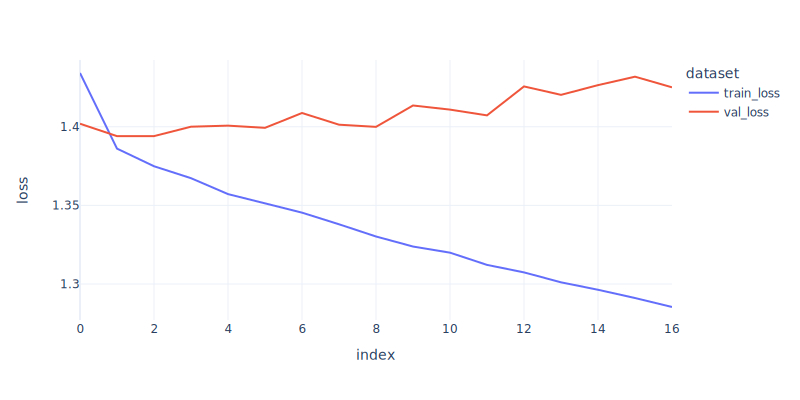

{'train': 0.6776426923445418,
 'val': 0.662597598045059,
 'test': 0.6724653708038795}

In [26]:
logs_df, model, scores = train_deep_surv(
    train, test, val, DeepHitSingle, tolerance=10, 
    print_lr=True, print_logs=True, verbose = True,
    **params
)

scores

In [27]:
grid_params = {
    "n_nodes" :[32, 64, 128],
    "n_layers" :[2, 4],
    "dropout" :[0.1, 0.3, 0.4],
    "lr" :[0.01, 0.005], 
    'model_params':[
        {'alpha': 0.2, 'sigma': 0.1, 'duration_index': labtrans.cuts},
        {'alpha': 0.8, 'sigma': 0.1, 'duration_index': labtrans.cuts}
                   ],
    'batch_size': [16],
    'discrete': [True]
}

best_model, table = grid_search_deep(train, val, test, num_durations, grid_params, DeepHitSingle)

72 total scenario to run
1/72: params: {'n_nodes': 32, 'n_layers': 2, 'dropout': 0.1, 'lr': 0.01, 'model_params': {'alpha': 0.2, 'sigma': 0.1}, 'batch_size': 16, 'discrete': True}
concordance: 0.65939
0:	[1s / 1s],		train_loss: 1.4162,	val_loss: 1.3935
1:	[0s / 1s],		train_loss: 1.3773,	val_loss: 1.3855
2:	[0s / 2s],		train_loss: 1.3579,	val_loss: 1.3864
3:	[0s / 3s],		train_loss: 1.3439,	val_loss: 1.3947
4:	[0s / 4s],		train_loss: 1.3269,	val_loss: 1.3985
concordance: 0.6935
5:	[1s / 5s],		train_loss: 1.3146,	val_loss: 1.4034
6:	[0s / 6s],		train_loss: 1.3043,	val_loss: 1.4044
7:	[0s / 7s],		train_loss: 1.2952,	val_loss: 1.4093
8:	[0s / 8s],		train_loss: 1.2865,	val_loss: 1.4111
9:	[0s / 9s],		train_loss: 1.2818,	val_loss: 1.4191
concordance: 0.69917
10:	[1s / 10s],		train_loss: 1.2704,	val_loss: 1.4188
11:	[0s / 11s],		train_loss: 1.2637,	val_loss: 1.4237
12:	[0s / 12s],		train_loss: 1.2620,	val_loss: 1.4320
13:	[0s / 13s],		train_loss: 1.2564,	val_loss: 1.4313
14:	:25s / 3m:39s],		t

concordance: 0.68835
10:	[0s / 16m:25s],		train_loss: 1.3219,	val_loss: 1.3979
11:	[0s / 16m:26s],		train_loss: 1.3194,	val_loss: 1.4032
12:	[0s / 16m:27s],		train_loss: 1.3175,	val_loss: 1.3976
13:	[0s / 16m:28s],		train_loss: 1.3121,	val_loss: 1.3980
14:	[0s / 16m:29s],		train_loss: 1.3091,	val_loss: 1.3990
concordance: 0.70184
15:	[0s / 16m:30s],		train_loss: 1.3101,	val_loss: 1.3972
16:	[0s / 16m:30s],		train_loss: 1.3077,	val_loss: 1.3982
17:	[0s / 16m:31s],		train_loss: 1.3064,	val_loss: 1.3987
18:	[0s / 16m:32s],		train_loss: 1.3064,	val_loss: 1.4001
19:	[0s / 16m:33s],		train_loss: 1.3016,	val_loss: 1.4009
Current score: 0.6691084803512536 vs. best score: 0.6784994983510152
8/72: params: {'n_nodes': 32, 'n_layers': 2, 'dropout': 0.3, 'lr': 0.005, 'model_params': {'alpha': 0.8, 'sigma': 0.1}, 'batch_size': 16, 'discrete': True}
concordance: 0.60224
0:	[0s / 0s],		train_loss: 4.6295,	val_loss: 4.5768
1:	[0s / 1s],		train_loss: 4.5131,	val_loss: 4.5725
2:	[0s / 2s],		train_loss: 4

8:	[1s / 12s],		train_loss: 1.3435,	val_loss: 1.3964
9:	[1s / 14s],		train_loss: 1.3417,	val_loss: 1.3885
concordance: 0.68963
10:	[1s / 15s],		train_loss: 1.3336,	val_loss: 1.3962
11:	[1s / 17s],		train_loss: 1.3298,	val_loss: 1.3973
12:	[1s / 18s],		train_loss: 1.3280,	val_loss: 1.3933
13:	[1s / 19s],		train_loss: 1.3254,	val_loss: 1.3967
14:	[1s / 21s],		train_loss: 1.3223,	val_loss: 1.4019
concordance: 0.69644
15:	[1s / 22s],		train_loss: 1.3192,	val_loss: 1.4009
16:	[1s / 24s],		train_loss: 1.3183,	val_loss: 1.4014
17:	[1s / 25s],		train_loss: 1.3146,	val_loss: 1.3958
18:	[1s / 26s],		train_loss: 1.3114,	val_loss: 1.4091
19:	[1s / 28s],		train_loss: 1.3103,	val_loss: 1.4094
concordance: 0.70095
20:	[1s / 29s],		train_loss: 1.3019,	val_loss: 1.4089
21:	[1s / 31s],		train_loss: 1.3048,	val_loss: 1.4080
22:	[1s / 32s],		train_loss: 1.2997,	val_loss: 1.4109
Current score: 0.68171986132634 vs. best score: 0.6784994983510152
14/72: params: {'n_nodes': 32, 'n_layers': 4, 'dropout': 0.1, 

18:	[1s / 26s],		train_loss: 4.4387,	val_loss: 4.6001
Current score: 0.5706336360611117 vs. best score: 0.6839903196646402
19/72: params: {'n_nodes': 32, 'n_layers': 4, 'dropout': 0.3, 'lr': 0.005, 'model_params': {'alpha': 0.2, 'sigma': 0.1}, 'batch_size': 16, 'discrete': True}
concordance: 0.61504
0:	[1s / 1s],		train_loss: 1.4346,	val_loss: 1.4101
1:	[1s / 2s],		train_loss: 1.4066,	val_loss: 1.4011
2:	[1s / 4s],		train_loss: 1.3947,	val_loss: 1.3939
3:	[1s / 5s],		train_loss: 1.3863,	val_loss: 1.3890
4:	[1s / 6s],		train_loss: 1.3802,	val_loss: 1.3876
concordance: 0.67913
5:	[1s / 8s],		train_loss: 1.3779,	val_loss: 1.3867
6:	[1s / 9s],		train_loss: 1.3709,	val_loss: 1.3840
7:	[1s / 11s],		train_loss: 1.3695,	val_loss: 1.3850
8:	[1s / 12s],		train_loss: 1.3667,	val_loss: 1.3866
9:	[1s / 13s],		train_loss: 1.3642,	val_loss: 1.3868
concordance: 0.69593
10:	[1s / 15s],		train_loss: 1.3642,	val_loss: 1.3873
11:	[1s / 16s],		train_loss: 1.3605,	val_loss: 1.3832
12:	[1s / 18s],		train_los

67:	[1s / 1m:33s],		train_loss: 1.3639,	val_loss: 1.3813
68:	[1s / 1m:35s],		train_loss: 1.3619,	val_loss: 1.3965
69:	[1s / 1m:36s],		train_loss: 1.3626,	val_loss: 1.3824
concordance: 0.70067
70:	[1s / 1m:37s],		train_loss: 1.3618,	val_loss: 1.3838
71:	[1s / 1m:39s],		train_loss: 1.3644,	val_loss: 1.3836
72:	[1s / 1m:40s],		train_loss: 1.3616,	val_loss: 1.3868
73:	[1s / 1m:42s],		train_loss: 1.3652,	val_loss: 1.3826
74:	[1s / 1m:43s],		train_loss: 1.3627,	val_loss: 1.3838
concordance: 0.70144
75:	[1s / 1m:44s],		train_loss: 1.3628,	val_loss: 1.3832
76:	[1s / 1m:46s],		train_loss: 1.3622,	val_loss: 1.3790
Current score: 0.6887690229268486 vs. best score: 0.6895124940398141
22/72: params: {'n_nodes': 32, 'n_layers': 4, 'dropout': 0.4, 'lr': 0.01, 'model_params': {'alpha': 0.8, 'sigma': 0.1}, 'batch_size': 16, 'discrete': True}
concordance: 0.48701
0:	[1s / 1s],		train_loss: 4.6199,	val_loss: 4.5866
1:	[1s / 2s],		train_loss: 4.5723,	val_loss: 4.5927
2:	[1s / 4s],		train_loss: 4.5673,	val

concordance: 0.66342
0:	[1s / 1s],		train_loss: 1.4230,	val_loss: 1.3903
1:	[0s / 2s],		train_loss: 1.3652,	val_loss: 1.3916
2:	[0s / 2s],		train_loss: 1.3416,	val_loss: 1.4003
3:	[0s / 3s],		train_loss: 1.3194,	val_loss: 1.4150
4:	[0s / 4s],		train_loss: 1.3010,	val_loss: 1.4179
concordance: 0.69246
5:	[1s / 5s],		train_loss: 1.2859,	val_loss: 1.4183
6:	[0s / 6s],		train_loss: 1.2660,	val_loss: 1.4313
7:	[0s / 7s],		train_loss: 1.2537,	val_loss: 1.4347
8:	[0s / 8s],		train_loss: 1.2392,	val_loss: 1.4603
9:	[1s / 9s],		train_loss: 1.2278,	val_loss: 1.4489
concordance: 0.69151
10:	[1s / 10s],		train_loss: 1.2212,	val_loss: 1.4628
11:	[0s / 11s],		train_loss: 1.2061,	val_loss: 1.4734
12:	[0s / 12s],		train_loss: 1.1963,	val_loss: 1.4822
13:	[0s / 13s],		train_loss: 1.1872,	val_loss: 1.4902
14:	[0s / 14s],		train_loss: 1.1828,	val_loss: 1.4968
concordance: 0.68716
15:	[1s / 15s],		train_loss: 1.1790,	val_loss: 1.5013
Current score: 0.6519041862856121 vs. best score: 0.6895124940398141
26/

concordance: 0.62437
0:	[1s / 1s],		train_loss: 4.6486,	val_loss: 4.5794
1:	[0s / 2s],		train_loss: 4.4674,	val_loss: 4.5893
2:	[1s / 3s],		train_loss: 4.3911,	val_loss: 4.6045
3:	[0s / 3s],		train_loss: 4.3327,	val_loss: 4.6312
4:	[0s / 4s],		train_loss: 4.2742,	val_loss: 4.6443
concordance: 0.64935
5:	[1s / 5s],		train_loss: 4.2314,	val_loss: 4.6516
6:	[0s / 6s],		train_loss: 4.1883,	val_loss: 4.6685
7:	[0s / 7s],		train_loss: 4.1553,	val_loss: 4.7117
8:	[1s / 8s],		train_loss: 4.1168,	val_loss: 4.7276
9:	[0s / 9s],		train_loss: 4.1001,	val_loss: 4.7346
concordance: 0.6557
10:	[1s / 10s],		train_loss: 4.0791,	val_loss: 4.7180
11:	[0s / 11s],		train_loss: 4.0461,	val_loss: 4.7469
12:	[0s / 12s],		train_loss: 4.0333,	val_loss: 4.7458
13:	[0s / 13s],		train_loss: 4.0230,	val_loss: 4.7672
14:	[0s / 14s],		train_loss: 3.9916,	val_loss: 4.7943
concordance: 0.65879
15:	[1s / 15s],		train_loss: 3.9764,	val_loss: 4.7925
Current score: 0.6211514893014662 vs. best score: 0.6895124940398141
33/7

12:	[1s / 19s],		train_loss: 4.1993,	val_loss: 4.7412
13:	[1s / 20s],		train_loss: 4.1753,	val_loss: 4.7343
14:	[1s / 22s],		train_loss: 4.1569,	val_loss: 4.7690
concordance: 0.67118
15:	[1s / 23s],		train_loss: 4.1241,	val_loss: 4.7835
16:	[1s / 25s],		train_loss: 4.1132,	val_loss: 4.8753
Current score: 0.6155287367882545 vs. best score: 0.6895124940398141
39/72: params: {'n_nodes': 64, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.005, 'model_params': {'alpha': 0.2, 'sigma': 0.1}, 'batch_size': 16, 'discrete': True}
concordance: 0.64501
0:	[1s / 1s],		train_loss: 1.4328,	val_loss: 1.4006
1:	[1s / 2s],		train_loss: 1.3802,	val_loss: 1.3885
2:	[1s / 4s],		train_loss: 1.3586,	val_loss: 1.3898
3:	[1s / 5s],		train_loss: 1.3463,	val_loss: 1.3891
4:	[1s / 7s],		train_loss: 1.3320,	val_loss: 1.3934
concordance: 0.68386
5:	[1s / 8s],		train_loss: 1.3224,	val_loss: 1.3972
6:	[1s / 10s],		train_loss: 1.3128,	val_loss: 1.4000
7:	[1s / 11s],		train_loss: 1.3018,	val_loss: 1.4124
8:	[1s / 13s],		train_l

concordance: 0.60023
0:	[1s / 1s],		train_loss: 1.4555,	val_loss: 1.4126
1:	[1s / 3s],		train_loss: 1.4102,	val_loss: 1.4029
2:	[1s / 4s],		train_loss: 1.4014,	val_loss: 1.3969
3:	[1s / 6s],		train_loss: 1.3944,	val_loss: 1.3997
4:	[1s / 7s],		train_loss: 1.3916,	val_loss: 1.3950
concordance: 0.67295
5:	[1s / 9s],		train_loss: 1.3899,	val_loss: 1.3917
6:	[1s / 10s],		train_loss: 1.3878,	val_loss: 1.3897
7:	[1s / 12s],		train_loss: 1.3848,	val_loss: 1.3907
8:	[1s / 13s],		train_loss: 1.3812,	val_loss: 1.3865
9:	[1s / 15s],		train_loss: 1.3784,	val_loss: 1.3879
concordance: 0.68505
10:	[1s / 16s],		train_loss: 1.3786,	val_loss: 1.3938
11:	[1s / 18s],		train_loss: 1.3762,	val_loss: 1.3886
12:	[1s / 19s],		train_loss: 1.3729,	val_loss: 1.3911
13:	[1s / 21s],		train_loss: 1.3731,	val_loss: 1.3933
14:	[1s / 22s],		train_loss: 1.3728,	val_loss: 1.3909
concordance: 0.69568
15:	[1s / 24s],		train_loss: 1.3690,	val_loss: 1.3894
16:	[1s / 25s],		train_loss: 1.3699,	val_loss: 1.3837
17:	[1s / 27s]

concordance: 0.66129
0:	[1s / 1s],		train_loss: 1.4879,	val_loss: 1.4010
1:	[1s / 2s],		train_loss: 1.3487,	val_loss: 1.3955
2:	[1s / 3s],		train_loss: 1.3172,	val_loss: 1.4083
3:	[1s / 4s],		train_loss: 1.2970,	val_loss: 1.4246
4:	[1s / 5s],		train_loss: 1.2778,	val_loss: 1.4371
concordance: 0.68107
5:	[1s / 6s],		train_loss: 1.2656,	val_loss: 1.4529
6:	[1s / 7s],		train_loss: 1.2493,	val_loss: 1.4429
7:	[1s / 8s],		train_loss: 1.2350,	val_loss: 1.4568
8:	[1s / 9s],		train_loss: 1.2079,	val_loss: 1.4849
9:	[1s / 11s],		train_loss: 1.1961,	val_loss: 1.4971
concordance: 0.68573
10:	[1s / 12s],		train_loss: 1.1818,	val_loss: 1.4943
11:	[1s / 13s],		train_loss: 1.1661,	val_loss: 1.5317
12:	[1s / 14s],		train_loss: 1.1742,	val_loss: 1.5297
13:	[1s / 15s],		train_loss: 1.1488,	val_loss: 1.5416
14:	[1s / 16s],		train_loss: 1.1391,	val_loss: 1.5544
concordance: 0.68374
15:	[1s / 17s],		train_loss: 1.1466,	val_loss: 1.5032
16:	[1s / 18s],		train_loss: 1.1348,	val_loss: 1.5628
Current score: 0.

concordance: 0.63045
0:	[1s / 1s],		train_loss: 4.6969,	val_loss: 4.5827
1:	[1s / 2s],		train_loss: 4.4160,	val_loss: 4.6042
2:	[1s / 3s],		train_loss: 4.2978,	val_loss: 4.6562
3:	[1s / 4s],		train_loss: 4.1994,	val_loss: 4.6798
4:	[1s / 5s],		train_loss: 4.1206,	val_loss: 4.7181
concordance: 0.65566
5:	[1s / 6s],		train_loss: 4.0439,	val_loss: 4.7469
6:	[1s / 7s],		train_loss: 3.9700,	val_loss: 4.7794
7:	[1s / 8s],		train_loss: 3.9321,	val_loss: 4.8098
8:	[1s / 9s],		train_loss: 3.8690,	val_loss: 4.8405
9:	[1s / 10s],		train_loss: 3.8297,	val_loss: 4.8989
concordance: 0.65794
10:	[1s / 12s],		train_loss: 3.7862,	val_loss: 4.8685
11:	[1s / 13s],		train_loss: 3.7413,	val_loss: 4.9568
12:	[1s / 14s],		train_loss: 3.7219,	val_loss: 4.9471
13:	[1s / 15s],		train_loss: 3.6950,	val_loss: 4.9388
14:	[1s / 16s],		train_loss: 3.6538,	val_loss: 4.9806
concordance: 0.65827
15:	[1s / 17s],		train_loss: 3.6524,	val_loss: 5.0238
Current score: 0.6249833921901696 vs. best score: 0.6930142585031986
57

11:	[1s / 19s],		train_loss: 4.1142,	val_loss: 4.8095
12:	[1s / 21s],		train_loss: 4.0725,	val_loss: 4.8656
13:	[1s / 23s],		train_loss: 4.0448,	val_loss: 4.9113
14:	[1s / 24s],		train_loss: 4.0057,	val_loss: 4.8728
concordance: 0.66151
15:	[1s / 26s],		train_loss: 3.9634,	val_loss: 4.9649
Current score: 0.5518041048297374 vs. best score: 0.6930142585031986
63/72: params: {'n_nodes': 128, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.005, 'model_params': {'alpha': 0.2, 'sigma': 0.1}, 'batch_size': 16, 'discrete': True}
concordance: 0.65694
0:	[1s / 1s],		train_loss: 1.4530,	val_loss: 1.4011
1:	[1s / 3s],		train_loss: 1.3711,	val_loss: 1.3911
2:	[1s / 5s],		train_loss: 1.3463,	val_loss: 1.3968
3:	[1s / 6s],		train_loss: 1.3268,	val_loss: 1.3994
4:	[1s / 8s],		train_loss: 1.3097,	val_loss: 1.4045
concordance: 0.68818
5:	[1s / 10s],		train_loss: 1.2936,	val_loss: 1.4152
6:	[1s / 11s],		train_loss: 1.2793,	val_loss: 1.4200
7:	[1s / 13s],		train_loss: 1.2663,	val_loss: 1.4262
8:	[1s / 15s],		train

7:	[1s / 13s],		train_loss: 4.3102,	val_loss: 4.6382
8:	[1s / 15s],		train_loss: 4.2876,	val_loss: 4.6457
9:	[1s / 17s],		train_loss: 4.2585,	val_loss: 4.6396
concordance: 0.66195
10:	[1s / 18s],		train_loss: 4.2334,	val_loss: 4.6779
11:	[1s / 20s],		train_loss: 4.2082,	val_loss: 4.6820
12:	[1s / 22s],		train_loss: 4.1951,	val_loss: 4.6621
13:	[1s / 24s],		train_loss: 4.1687,	val_loss: 4.7043
14:	[1s / 25s],		train_loss: 4.1547,	val_loss: 4.7300
concordance: 0.66614
15:	[1s / 27s],		train_loss: 4.1351,	val_loss: 4.7076
16:	[1s / 29s],		train_loss: 4.1156,	val_loss: 4.7178
17:	[1s / 30s],		train_loss: 4.1007,	val_loss: 4.7510
Current score: 0.630400487245202 vs. best score: 0.6930142585031986
69/72: params: {'n_nodes': 128, 'n_layers': 4, 'dropout': 0.4, 'lr': 0.01, 'model_params': {'alpha': 0.2, 'sigma': 0.1}, 'batch_size': 16, 'discrete': True}
concordance: 0.59633
0:	[1s / 1s],		train_loss: 1.5342,	val_loss: 1.4138
1:	[1s / 3s],		train_loss: 1.4087,	val_loss: 1.4031
2:	[1s / 5s],		tr

In [ ]:
table['model'] = 'DeepHit'

table_final = pd.concat([table_final, table.iloc[:1]], axis=0).reset_index(drop=True)

In [ ]:
table_final = pd.concat([table_final,
           scores_ml_df.T.rename(columns={d:'score_'+d for d in ['train', 'test']})\
            .reset_index().rename(columns={'index':'model'})], axis=0)
cols = ['model'] +['score_' + d for d in ['train', 'test']]

table_final = table_final[cols+ [c for c in table_final.columns if c not in cols]]

In [48]:
table_final.to_csv(os.path.join(path_dir, "outputs","model_scores_dl.csv"), index=False)

In [28]:
best_model.save_net(os.path.join(path_dir, "outputs","models","deephit.pt"))

In [31]:
table_final

,n_nodes,n_layers,dropout,lr,score_train,score_val,score_test,model,model_params,batch_size,discrete
0,64,4,0.4,0.01,0.721537,0.695406,0.691087,DeepSurv,NaN,NaN,NaN
1,64,4,0.4,0.01,0.721470,0.707535,0.693014,DeepHit,"{'alpha': 0.2, 'sigma': 0.1}",16.0,True
